In [1]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

In [2]:
# 0 : pas de frande liée à une transaction
# 1 :  frande liée à une transaction

# https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [1]:
import numpy as np
import pandas as pd
import datatable as dt
import gc
from joblib import load, dump
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<IPython.core.display.HTML object>

## Première partie : Feature Engineering

In [4]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [5]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### Valeur aberrante, 

In [6]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [7]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg

In [8]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)

    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    
    return prev_agg

In [9]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    
    return pos_agg

In [10]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)

    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    
    return ins_agg

In [11]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)

    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    
    return cc_agg

In [12]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        
    return df 

In [13]:
# LightGBMError : On change les caractères spéciaux dans le nom de la colonne de `df`.
# Supprimer tous les sympoles spéciaux
# Remplacer toules infini par Nan 

import re
if __name__ == "__main__":
    with timer("Full model run"):
      df= main()

      df = df.replace([np.inf, -np.inf], np.nan)
      df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

      df.to_csv("df.csv",index=False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 38s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 44s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 23s
Installments payments df shape: (339587, 26)
Process installments payments - done in 44s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 61s
Full model run - done in 393s


In [14]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [15]:
train_df.to_csv("train_df.csv", index =False)
test_df.to_csv("test_df.csv", index =False)

## Deuxième partie : Feature Importance

In [16]:
df.TARGET.value_counts(normalize=True , dropna=False).to_frame().style.background_gradient('cividis')

,TARGET
0.0,0.793491
nan,0.136825
1.0,0.069684


In [17]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
# stratified = False, car df est déséquilibre


def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
    print(folds)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    print(feats[:3])
    
    # split(X,y=None, groups = None)  => X : train_df[feats], y =>train_df['TARGET]
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
                   
        # Sauvegarder le modele        
        dump(clf, 'LGBMC.joblib')
        del clf,train_x, train_y, valid_x, valid_y
        gc.collect()
        
        
    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    
    
    
    feature_importance_df.to_csv("feature_importance_df.csv", index=False)
    
    
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        submission_file_name = "submission_kernel02.csv"
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
        


In [18]:
kfold_lightgbm(df, num_folds= 10, stratified= False)

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
KFold(n_splits=10, random_state=1001, shuffle=True)
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797104	training's binary_logloss: 0.234829	valid_1's auc: 0.776089	valid_1's binary_logloss: 0.246759
[400]	training's auc: 0.819226	training's binary_logloss: 0.22537	valid_1's auc: 0.787159	valid_1's binary_logloss: 0.242511
[600]	training's auc: 0.834156	training's binary_logloss: 0.219272	valid_1's auc: 0.790698	valid_1's binary_logloss: 0.241198
[800]	training's auc: 0.84611	training's binary_logloss: 0.21431	valid_1's auc: 0.792595	valid_1's binary_logloss: 0.240589
[1000]	training's auc: 0.856645	training's binary_logloss: 0.209866	valid_1's auc: 0.79355	valid_1's binary_logloss: 0.24027
[1200]	training's auc: 0.866401	training's binary_logloss: 0.205708	valid_1's auc: 0.794057	valid_1's binary_logloss: 0.240123
[1400]	training's auc: 0.875282	training's binary_logloss: 0.201766	valid_1's auc: 0.794297	valid_1's binary_logloss: 0.240025
[

/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796504	training's binary_logloss: 0.235573	valid_1's auc: 0.777058	valid_1's binary_logloss: 0.241702
[400]	training's auc: 0.819063	training's binary_logloss: 0.226043	valid_1's auc: 0.786754	valid_1's binary_logloss: 0.237454
[600]	training's auc: 0.833962	training's binary_logloss: 0.21997	valid_1's auc: 0.788941	valid_1's binary_logloss: 0.236447
[800]	training's auc: 0.846242	training's binary_logloss: 0.214952	valid_1's auc: 0.790163	valid_1's binary_logloss: 0.235943
[1000]	training's auc: 0.856358	training's binary_logloss: 0.210596	valid_1's auc: 0.790747	valid_1's binary_logloss: 0.235697
[1200]	training's auc: 0.865662	training's binary_logloss: 0.20657	valid_1's auc: 0.791263	valid_1's binary_logloss: 0.235542
[1400]	training's auc: 0.874365	training's binary_logloss: 0.202665	valid_1's auc: 0.791252	valid_1's binary_logloss: 0.2355


/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797097	training's binary_logloss: 0.235026	valid_1's auc: 0.76787	valid_1's binary_logloss: 0.246536
[400]	training's auc: 0.819952	training's binary_logloss: 0.225433	valid_1's auc: 0.77831	valid_1's binary_logloss: 0.242546
[600]	training's auc: 0.834998	training's binary_logloss: 0.219239	valid_1's auc: 0.781675	valid_1's binary_logloss: 0.241423
[800]	training's auc: 0.847146	training's binary_logloss: 0.214195	valid_1's auc: 0.783388	valid_1's binary_logloss: 0.240839
[1000]	training's auc: 0.857393	training's binary_logloss: 0.209832	valid_1's auc: 0.784432	valid_1's binary_logloss: 0.240554
[1200]	training's auc: 0.866948	training's binary_logloss: 0.205647	valid_1's auc: 0.784983	valid_1's binary_logloss: 0.2404
[1400]	training's auc: 0.875487	training's binary_logloss: 0.201791	valid_1's auc: 0.785176	valid_1's binary_logloss: 0.240401


/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796781	training's binary_logloss: 0.23554	valid_1's auc: 0.778094	valid_1's binary_logloss: 0.241263
[400]	training's auc: 0.81928	training's binary_logloss: 0.225978	valid_1's auc: 0.788498	valid_1's binary_logloss: 0.236955
[600]	training's auc: 0.834434	training's binary_logloss: 0.219853	valid_1's auc: 0.792259	valid_1's binary_logloss: 0.235479
[800]	training's auc: 0.846298	training's binary_logloss: 0.214997	valid_1's auc: 0.793655	valid_1's binary_logloss: 0.23492
[1000]	training's auc: 0.856943	training's binary_logloss: 0.210483	valid_1's auc: 0.79455	valid_1's binary_logloss: 0.234589
[1200]	training's auc: 0.866468	training's binary_logloss: 0.206359	valid_1's auc: 0.795305	valid_1's binary_logloss: 0.234344
[1400]	training's auc: 0.87528	training's binary_logloss: 0.202416	valid_1's auc: 0.795796	valid_1's binary_logloss: 0.234162
[

/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796443	training's binary_logloss: 0.236317	valid_1's auc: 0.78032	valid_1's binary_logloss: 0.234124
[400]	training's auc: 0.819068	training's binary_logloss: 0.226741	valid_1's auc: 0.790482	valid_1's binary_logloss: 0.229854
[600]	training's auc: 0.833992	training's binary_logloss: 0.220619	valid_1's auc: 0.793639	valid_1's binary_logloss: 0.228569
[800]	training's auc: 0.846192	training's binary_logloss: 0.215603	valid_1's auc: 0.795317	valid_1's binary_logloss: 0.227936
[1000]	training's auc: 0.856565	training's binary_logloss: 0.211185	valid_1's auc: 0.796372	valid_1's binary_logloss: 0.22758
[1200]	training's auc: 0.865942	training's binary_logloss: 0.207098	valid_1's auc: 0.796874	valid_1's binary_logloss: 0.227377
[1400]	training's auc: 0.874589	training's binary_logloss: 0.20322	valid_1's auc: 0.797234	valid_1's binary_logloss: 0.227289

/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797404	training's binary_logloss: 0.235337	valid_1's auc: 0.76717	valid_1's binary_logloss: 0.243343
[400]	training's auc: 0.820012	training's binary_logloss: 0.225758	valid_1's auc: 0.778167	valid_1's binary_logloss: 0.239452
[600]	training's auc: 0.835049	training's binary_logloss: 0.219617	valid_1's auc: 0.782224	valid_1's binary_logloss: 0.238116
[800]	training's auc: 0.847157	training's binary_logloss: 0.214639	valid_1's auc: 0.783884	valid_1's binary_logloss: 0.237496
[1000]	training's auc: 0.857712	training's binary_logloss: 0.210155	valid_1's auc: 0.784849	valid_1's binary_logloss: 0.237177
[1200]	training's auc: 0.867235	training's binary_logloss: 0.205973	valid_1's auc: 0.785466	valid_1's binary_logloss: 0.236928
[1400]	training's auc: 0.87616	training's binary_logloss: 0.201876	valid_1's auc: 0.785705	valid_1's binary_logloss: 0.23685

/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797268	training's binary_logloss: 0.235527	valid_1's auc: 0.774539	valid_1's binary_logloss: 0.240657
[400]	training's auc: 0.819627	training's binary_logloss: 0.225979	valid_1's auc: 0.784495	valid_1's binary_logloss: 0.236476
[600]	training's auc: 0.834715	training's binary_logloss: 0.219849	valid_1's auc: 0.787924	valid_1's binary_logloss: 0.235197
[800]	training's auc: 0.846754	training's binary_logloss: 0.214933	valid_1's auc: 0.789387	valid_1's binary_logloss: 0.234711
[1000]	training's auc: 0.857246	training's binary_logloss: 0.210556	valid_1's auc: 0.790167	valid_1's binary_logloss: 0.234452
[1200]	training's auc: 0.86674	training's binary_logloss: 0.20641	valid_1's auc: 0.790378	valid_1's binary_logloss: 0.234369
Fold  7 AUC : 0.790485


/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797384	training's binary_logloss: 0.235077	valid_1's auc: 0.770478	valid_1's binary_logloss: 0.245343
[400]	training's auc: 0.819702	training's binary_logloss: 0.225544	valid_1's auc: 0.781769	valid_1's binary_logloss: 0.240998
[600]	training's auc: 0.834425	training's binary_logloss: 0.219493	valid_1's auc: 0.786012	valid_1's binary_logloss: 0.23951
[800]	training's auc: 0.846047	training's binary_logloss: 0.214726	valid_1's auc: 0.787919	valid_1's binary_logloss: 0.23886
[1000]	training's auc: 0.856655	training's binary_logloss: 0.210293	valid_1's auc: 0.78906	valid_1's binary_logloss: 0.238453
[1200]	training's auc: 0.866183	training's binary_logloss: 0.206126	valid_1's auc: 0.789716	valid_1's binary_logloss: 0.238288
[1400]	training's auc: 0.87484	training's binary_logloss: 0.202211	valid_1's auc: 0.790159	valid_1's binary_logloss: 0.238168


/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796271	training's binary_logloss: 0.235443	valid_1's auc: 0.78095	valid_1's binary_logloss: 0.242432
[400]	training's auc: 0.819217	training's binary_logloss: 0.225821	valid_1's auc: 0.790889	valid_1's binary_logloss: 0.238024
[600]	training's auc: 0.834482	training's binary_logloss: 0.219602	valid_1's auc: 0.794164	valid_1's binary_logloss: 0.236667
[800]	training's auc: 0.846516	training's binary_logloss: 0.214606	valid_1's auc: 0.795267	valid_1's binary_logloss: 0.236102
[1000]	training's auc: 0.857025	training's binary_logloss: 0.210197	valid_1's auc: 0.795732	valid_1's binary_logloss: 0.235873
[1200]	training's auc: 0.866886	training's binary_logloss: 0.205937	valid_1's auc: 0.796417	valid_1's binary_logloss: 0.235606
[1400]	training's auc: 0.875787	training's binary_logloss: 0.201939	valid_1's auc: 0.796829	valid_1's binary_logloss: 0.2354

/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796896	training's binary_logloss: 0.235586	valid_1's auc: 0.771623	valid_1's binary_logloss: 0.240838
[400]	training's auc: 0.819521	training's binary_logloss: 0.226054	valid_1's auc: 0.782653	valid_1's binary_logloss: 0.236584
[600]	training's auc: 0.834425	training's binary_logloss: 0.219956	valid_1's auc: 0.786156	valid_1's binary_logloss: 0.235272
[800]	training's auc: 0.846621	training's binary_logloss: 0.214988	valid_1's auc: 0.787993	valid_1's binary_logloss: 0.234571
[1000]	training's auc: 0.857497	training's binary_logloss: 0.210439	valid_1's auc: 0.788599	valid_1's binary_logloss: 0.234316
[1200]	training's auc: 0.867333	training's binary_logloss: 0.206162	valid_1's auc: 0.789137	valid_1's binary_logloss: 0.234125
[1400]	training's auc: 0.876078	training's binary_logloss: 0.202211	valid_1's auc: 0.789402	valid_1's binary_logloss: 0.234

<ipython-input-17-c4ee62a0efee>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


In [ ]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

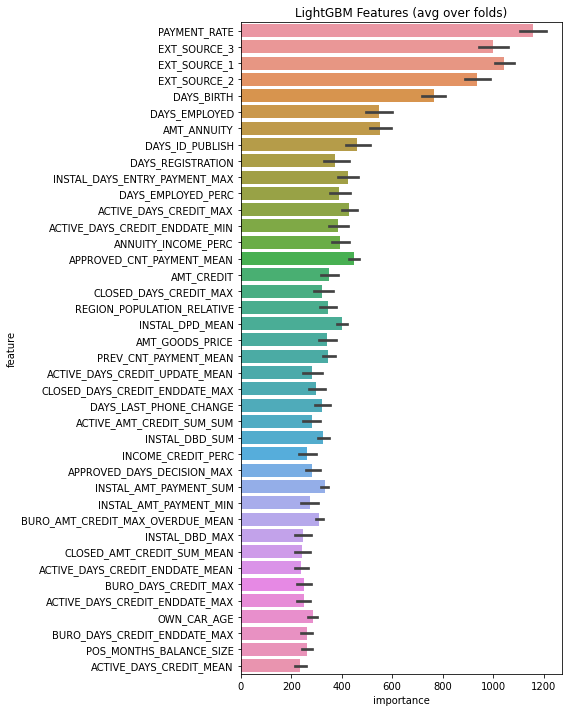

In [20]:
feature_importance_df =pd.read_csv("feature_importance_df.csv", sep=',')
display_importances(feature_importance_df)

In [2]:
clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

train_df = dt.fread('train_df.csv', sep=',').to_pandas()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
train_x = train_df[feats]
train_y = train_df['TARGET']
clf.fit(train_x, train_y)

/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

In [9]:
dump(clf,'LightGBMC.joblib')

['LightGBMC.joblib']

# Avec SMOTE

In [2]:
import numpy as np
import pandas as pd
import datatable as dt  # pip install git+https://github.com/h2oai/datatable
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/ying/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ying/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [1]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
# stratified = False, car df est déséquilibre
from imblearn.over_sampling import SMOTE



def kfold_lightgbm_smote(df, num_folds, stratified = False, debug= False):
    
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
    print(folds)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
   
    

    # Imputer les valeurs manquantes with SimpleImputer
    from sklearn.impute import SimpleImputer
    mean_imputer = SimpleImputer(strategy='most_frequent')
    train_df = pd.DataFrame( mean_imputer.fit_transform(train_df), columns=train_df.columns)
    
    # Pour le sur-échantillonnage, l’algorithme SMOTE (Synthetic Minority Oversampling Technique) fait référence. 
    # Cet algorithme va permettre de créer des individus proches de ceux de la classe minoritaire afin de surreprésenter cette classe
    sur_echant = SMOTE()
    
    
    # split(X,y=None, groups = None)  => X : train_df[feats], y =>train_df['TARGET]
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        # on applique la méthode fit_resample() sur nos données
        train_x_sur, train_y_sur = sur_echant.fit_resample(train_x,train_y)

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x_sur, train_y_sur, eval_set=[(train_x_sur, train_y_sur), (valid_x, valid_y)], eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        
      
        del clf, train_x_sur, train_y_sur, valid_x, valid_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    
    
    feature_importance_df.to_csv("feature_importance_df_smote.csv", index=False)
    
    
    
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        submission_file_name = "submission_kernel_smote.csv"
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
        


In [3]:
df = dt.fread('df.csv', sep=',').to_pandas()
print("df shape: {}".format(df.shape))

df shape: (356251, 798)


In [4]:
# On entraine le modèle d'abord avec 20% des données
sample_df = df.sample(int(len(df) * 0.5))
print("sample_df Shape:{}".format(sample_df.shape))

sample_df Shape:(178125, 798)


In [5]:

kfold_lightgbm_smote(sample_df, num_folds= 10, stratified= False)

Starting LightGBM. Train shape: (153791, 798), test shape: (24334, 798)
KFold(n_splits=10, random_state=1001, shuffle=True)


/home/ying/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ying/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argumen

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.97996	training's binary_logloss: 0.159505	valid_1's auc: 0.750075	valid_1's binary_logloss: 0.259262
[400]	training's auc: 0.983628	training's binary_logloss: 0.131203	valid_1's auc: 0.771372	valid_1's binary_logloss: 0.24328
[600]	training's auc: 0.985833	training's binary_logloss: 0.12214	valid_1's auc: 0.779253	valid_1's binary_logloss: 0.2395
[800]	training's auc: 0.987471	training's binary_logloss: 0.116734	valid_1's auc: 0.781455	valid_1's binary_logloss: 0.238341
[1000]	training's auc: 0.988826	training's binary_logloss: 0.112577	valid_1's auc: 0.782124	valid_1's binary_logloss: 0.23798
[1200]	training's auc: 0.98999	training's binary_logloss: 0.108963	valid_1's auc: 0.782768	valid_1's binary_logloss: 0.237776
[1400]	training's auc: 0.991042	training's binary_logloss: 0.105604	valid_1's auc: 0.782729	valid_1's binary_logloss: 0.237782
Fol

/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.979953	training's binary_logloss: 0.159685	valid_1's auc: 0.756952	valid_1's binary_logloss: 0.259524
[400]	training's auc: 0.983561	training's binary_logloss: 0.131105	valid_1's auc: 0.782306	valid_1's binary_logloss: 0.242364
[600]	training's auc: 0.985806	training's binary_logloss: 0.122058	valid_1's auc: 0.790277	valid_1's binary_logloss: 0.238355
[800]	training's auc: 0.987546	training's binary_logloss: 0.116413	valid_1's auc: 0.792938	valid_1's binary_logloss: 0.237048
[1000]	training's auc: 0.988892	training's binary_logloss: 0.112301	valid_1's auc: 0.794762	valid_1's binary_logloss: 0.236306
[1200]	training's auc: 0.990095	training's binary_logloss: 0.108616	valid_1's auc: 0.795636	valid_1's binary_logloss: 0.235994
[1400]	training's auc: 0.991141	training's binary_logloss: 0.10524	valid_1's auc: 0.796172	valid_1's binary_logloss: 0.2358

/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.980007	training's binary_logloss: 0.15985	valid_1's auc: 0.745295	valid_1's binary_logloss: 0.25618
[400]	training's auc: 0.983645	training's binary_logloss: 0.13119	valid_1's auc: 0.765769	valid_1's binary_logloss: 0.240401
[600]	training's auc: 0.985915	training's binary_logloss: 0.122154	valid_1's auc: 0.770744	valid_1's binary_logloss: 0.237657
[800]	training's auc: 0.98756	training's binary_logloss: 0.116675	valid_1's auc: 0.772623	valid_1's binary_logloss: 0.236836
[1000]	training's auc: 0.988922	training's binary_logloss: 0.112431	valid_1's auc: 0.773167	valid_1's binary_logloss: 0.236482
[1200]	training's auc: 0.99008	training's binary_logloss: 0.108747	valid_1's auc: 0.773283	valid_1's binary_logloss: 0.236463
Fold  3 AUC : 0.773528


/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.979879	training's binary_logloss: 0.159867	valid_1's auc: 0.742492	valid_1's binary_logloss: 0.255344
[400]	training's auc: 0.983591	training's binary_logloss: 0.131431	valid_1's auc: 0.770068	valid_1's binary_logloss: 0.238084
[600]	training's auc: 0.985811	training's binary_logloss: 0.122236	valid_1's auc: 0.777633	valid_1's binary_logloss: 0.234671
[800]	training's auc: 0.987468	training's binary_logloss: 0.116725	valid_1's auc: 0.780455	valid_1's binary_logloss: 0.233572
[1000]	training's auc: 0.988781	training's binary_logloss: 0.112679	valid_1's auc: 0.781947	valid_1's binary_logloss: 0.233046
[1200]	training's auc: 0.989882	training's binary_logloss: 0.109288	valid_1's auc: 0.78294	valid_1's binary_logloss: 0.23271
[1400]	training's auc: 0.990974	training's binary_logloss: 0.105833	valid_1's auc: 0.783369	valid_1's binary_logloss: 0.23255

/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.980108	training's binary_logloss: 0.158798	valid_1's auc: 0.750229	valid_1's binary_logloss: 0.265412
[400]	training's auc: 0.983722	training's binary_logloss: 0.130573	valid_1's auc: 0.772871	valid_1's binary_logloss: 0.24989
[600]	training's auc: 0.985931	training's binary_logloss: 0.121512	valid_1's auc: 0.779679	valid_1's binary_logloss: 0.246638
[800]	training's auc: 0.987592	training's binary_logloss: 0.116068	valid_1's auc: 0.782806	valid_1's binary_logloss: 0.245256
[1000]	training's auc: 0.988921	training's binary_logloss: 0.111924	valid_1's auc: 0.784594	valid_1's binary_logloss: 0.244563
[1200]	training's auc: 0.990031	training's binary_logloss: 0.108448	valid_1's auc: 0.785856	valid_1's binary_logloss: 0.244135
[1400]	training's auc: 0.991024	training's binary_logloss: 0.105294	valid_1's auc: 0.786976	valid_1's binary_logloss: 0.2437

/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.980068	training's binary_logloss: 0.158751	valid_1's auc: 0.747998	valid_1's binary_logloss: 0.260754
[400]	training's auc: 0.983675	training's binary_logloss: 0.130833	valid_1's auc: 0.768665	valid_1's binary_logloss: 0.245501
[600]	training's auc: 0.985896	training's binary_logloss: 0.121718	valid_1's auc: 0.77585	valid_1's binary_logloss: 0.242211
[800]	training's auc: 0.987548	training's binary_logloss: 0.116345	valid_1's auc: 0.778264	valid_1's binary_logloss: 0.241372
[1000]	training's auc: 0.988948	training's binary_logloss: 0.11207	valid_1's auc: 0.779051	valid_1's binary_logloss: 0.241027
[1200]	training's auc: 0.990112	training's binary_logloss: 0.108375	valid_1's auc: 0.778963	valid_1's binary_logloss: 0.240992
Fold  6 AUC : 0.779334


/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.980078	training's binary_logloss: 0.159232	valid_1's auc: 0.748154	valid_1's binary_logloss: 0.263309
[400]	training's auc: 0.983778	training's binary_logloss: 0.130552	valid_1's auc: 0.771952	valid_1's binary_logloss: 0.248007
[600]	training's auc: 0.985979	training's binary_logloss: 0.121443	valid_1's auc: 0.779311	valid_1's binary_logloss: 0.245072
[800]	training's auc: 0.987629	training's binary_logloss: 0.11607	valid_1's auc: 0.782077	valid_1's binary_logloss: 0.244098
[1000]	training's auc: 0.988909	training's binary_logloss: 0.11206	valid_1's auc: 0.783325	valid_1's binary_logloss: 0.243794
[1200]	training's auc: 0.990058	training's binary_logloss: 0.108448	valid_1's auc: 0.783438	valid_1's binary_logloss: 0.243737
Fold  7 AUC : 0.783361


/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.980085	training's binary_logloss: 0.159332	valid_1's auc: 0.748285	valid_1's binary_logloss: 0.260189
[400]	training's auc: 0.98377	training's binary_logloss: 0.130908	valid_1's auc: 0.76768	valid_1's binary_logloss: 0.244811
[600]	training's auc: 0.986004	training's binary_logloss: 0.121753	valid_1's auc: 0.77361	valid_1's binary_logloss: 0.241866
[800]	training's auc: 0.987641	training's binary_logloss: 0.116331	valid_1's auc: 0.775527	valid_1's binary_logloss: 0.241011
[1000]	training's auc: 0.989005	training's binary_logloss: 0.112067	valid_1's auc: 0.775684	valid_1's binary_logloss: 0.240799
Fold  8 AUC : 0.775995


/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.979933	training's binary_logloss: 0.159383	valid_1's auc: 0.745737	valid_1's binary_logloss: 0.255528
[400]	training's auc: 0.983576	training's binary_logloss: 0.13122	valid_1's auc: 0.768826	valid_1's binary_logloss: 0.239258
[600]	training's auc: 0.985813	training's binary_logloss: 0.122349	valid_1's auc: 0.775123	valid_1's binary_logloss: 0.236115
[800]	training's auc: 0.987432	training's binary_logloss: 0.116912	valid_1's auc: 0.778081	valid_1's binary_logloss: 0.234925
[1000]	training's auc: 0.988808	training's binary_logloss: 0.112638	valid_1's auc: 0.780287	valid_1's binary_logloss: 0.234167
[1200]	training's auc: 0.990042	training's binary_logloss: 0.108762	valid_1's auc: 0.781442	valid_1's binary_logloss: 0.23389
[1400]	training's auc: 0.991066	training's binary_logloss: 0.10544	valid_1's auc: 0.781997	valid_1's binary_logloss: 0.233742

/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be remov

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.980037	training's binary_logloss: 0.15906	valid_1's auc: 0.748975	valid_1's binary_logloss: 0.26091
[400]	training's auc: 0.983721	training's binary_logloss: 0.130856	valid_1's auc: 0.772423	valid_1's binary_logloss: 0.244323
[600]	training's auc: 0.985977	training's binary_logloss: 0.121634	valid_1's auc: 0.77858	valid_1's binary_logloss: 0.241043
[800]	training's auc: 0.987718	training's binary_logloss: 0.116128	valid_1's auc: 0.780748	valid_1's binary_logloss: 0.239995
[1000]	training's auc: 0.989023	training's binary_logloss: 0.112071	valid_1's auc: 0.781941	valid_1's binary_logloss: 0.239513
[1200]	training's auc: 0.990167	training's binary_logloss: 0.108509	valid_1's auc: 0.781814	valid_1's binary_logloss: 0.239507
Fold 10 AUC : 0.782177
Full AUC score 0.782743


<ipython-input-1-c36f10fc4534>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


In [6]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances_smote.png')

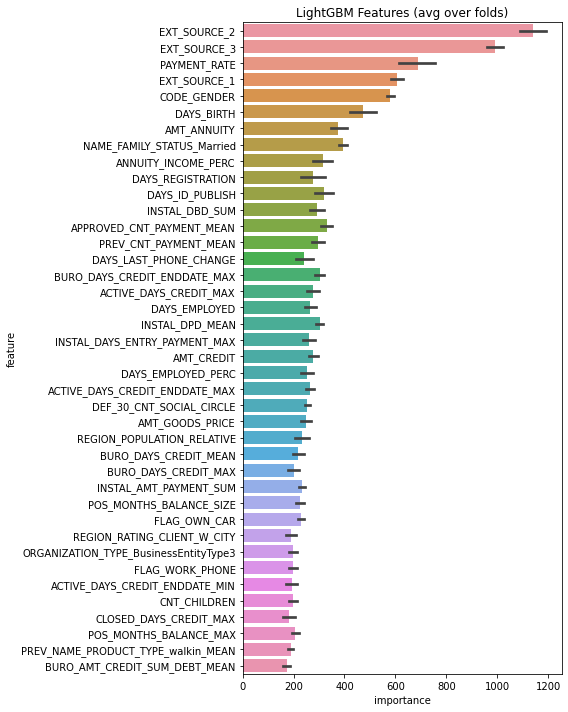

In [7]:
feature_importance_df_smote =pd.read_csv("feature_importance_df_smote.csv", sep=',')
display_importances(feature_importance_df_smote)